# **Continuous Values Model**

In this notebook we will create a dataframe which only includes continuous numeric values. We will then create a model on only these values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error, f1_score, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
train = pd.read_csv('./data/large_train_sample.csv')
test = pd.read_csv('./data/test_data.csv')

In [3]:
print(f'Train csv shape is {train.shape}')
print(f'Test csv shape is {test.shape}')

Train csv shape is (32561, 14)
Test csv shape is (16281, 13)


In [4]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,Cuba,<=50K


In [5]:
# We have imbalanced classes
# This is the baseline
train['wage'].value_counts(normalize=True)

 <=50K    0.75919
 >50K     0.24081
Name: wage, dtype: float64

In [6]:
# Binarizing Wage Column

train['wage'] = pd.get_dummies(train['wage'], drop_first=True)

In [7]:
# Baseline Accuracy Score

train['wage'].value_counts(normalize=True)

0    0.75919
1    0.24081
Name: wage, dtype: float64

In [8]:
# Creating dataframe with just continuous numeric values

train = train[train.describe().columns]

In [9]:
train.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,wage
0,39,77516,13,2174,0,40,0
1,50,83311,13,0,0,13,0
2,38,215646,9,0,0,40,0
3,53,234721,7,0,0,40,0
4,28,338409,13,0,0,40,0


In [10]:
#Credit to Chris

# Function that generates all the value counts for each column

def columns_values(dataframe):
    for n in dataframe.columns:                               # cycle through the columns in dataframe
        column = n  
        value_counts = (dataframe[column].value_counts())     # run value counts for each column
        unique_values = (dataframe[column].unique())          # run unique values for each column 
        len_counts = len(value_counts)                        # how many items are counted in value counts
        len_unique = len(unique_values)                       # how many items are counted in unique values
        if (len(value_counts)< 100):                          # ignore columns where counts over 100
                print(f"{column} has length of {len_unique}") # print how many unique values there are
                print(unique_values)                          # print unique values for column 
                print("="*30)                                  
                print(f"{column} has length of {len_counts}") # print how many values are counted
                print(value_counts)                           # print unique values counted
                print("="*60)

In [11]:
columns_values(train)

age has length of 73
[39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
 87]
age has length of 73
36    898
31    888
34    886
23    877
35    876
33    875
28    867
30    861
37    858
25    841
27    835
32    828
38    827
39    816
29    813
41    808
24    798
40    794
26    785
42    780
43    770
22    765
20    753
46    737
45    734
44    724
21    720
19    712
47    708
50    602
51    595
49    577
18    550
48    543
52    478
53    464
55    419
54    415
17    395
58    366
56    366
57    358
59    355
60    312
61    300
62    258
63    230
64    208
65    178
67    151
66    150
68    120
69    108
70     89
71     72
72     67
73     64
74     51
76     46
75     45
90     43
77     29
78     23
80     22
79     22
81     20
82     12
84     10
83      6
85      3
88      3
87      1
86      1
Name

In [12]:
# Education num is the amount of years someone went to school?
# Capital-gain and hours-per-week are capped at 99,999 and 99
# Capital-gain there are 157 people at 99,999 and hours-per-week are 85 for 99
# 20 people with only 1 for hours-per-week
# 1836 who are working class ?
# 1843 whos occupation is a ?
# 583 native country ?

# We chose to leave these in

In [13]:
train.head(2)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,wage
0,39,77516,13,2174,0,40,0
1,50,83311,13,0,0,13,0


In [14]:
# train_col = ['age',
#             'fnlwgt',
#             'education-num',
#             'capital-gain',
#             'capital-loss',
#             'hours-per-week',
#             'wage'    
#             ]

In [15]:
# Descriptive Statistics of numeric data prior to handling outliers

train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,wage
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456,0.240810
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429,0.427581
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [16]:
# Shape of data prior to handling outliers
print(f'Train csv shape is {train.shape}')
print(f'Test csv shape is {test.shape}')

Train csv shape is (32561, 7)
Test csv shape is (16281, 13)


In [17]:
# looping through outliers to remove any instances where there is a numeric 
# value that is greater than three standard deviations from the mean

for col in train:
    outlier = abs(train[col].std() * 3) + abs(train[col].mean())
    train.drop(train[train[col] > outlier].index, inplace=True)

In [18]:
# Descriptive Statistics of numeric data after handling outliers

train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,wage
count,30108.000000,30108.000000,30108.000000,30108.000000,30108.000000,30108.000000,30108.000000
mean,38.226485,185488.998738,10.022486,567.151156,1.212037,39.784011,0.221503
std,13.424234,94667.976151,2.538230,2326.937114,32.648206,11.294637,0.415265
min,17.000000,12285.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,27.000000,117606.000000,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,177817.000000,10.000000,0.000000,0.000000,40.000000,0.000000
75%,47.000000,234723.500000,12.000000,0.000000,0.000000,45.000000,0.000000
max,79.000000,506436.000000,16.000000,22040.000000,1258.000000,77.000000,1.000000


In [19]:
train.shape

(30108, 7)

In [20]:
# Shape of data after handling outliers
print(f'Train csv shape is {train.shape}')


Train csv shape is (30108, 7)


## **Continuous Modeling**

In [21]:
X = train[train.describe().columns[:-1]]
y = train['wage']

In [22]:
print(X.shape)
print(y.shape)

(30108, 6)
(30108,)


In [23]:
# Instantiate Standard Scaler

sc = StandardScaler()

# Create train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Fiting to the training data, and transforming training and testing data

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [24]:
#Instantiate Random Forest

rf = RandomForestClassifier()

# Fit the model on training data

rf.fit(X_train_sc, y_train);

In [25]:
print(f'Continuous Model Train Score is {rf.score(X_train_sc, y_train)}')
print(f'Continuous Model Train Score is {rf.score(X_test_sc, y_test)}')

Continuous Model Train Score is 0.998892874540543
Continuous Model Train Score is 0.8090872857712236


In [26]:
# Setting our parameters for the random forest to be used in the gridsearch

rf_params = {
    'n_estimators': [250, 300],
    'max_depth': [7, 9, 12],
    'ccp_alpha' : [0.0001],
}

# Instantiate the Gridsearch

gs = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs=-1)

# fit the gridsearch to the training data
gs.fit(X_train_sc, y_train);

In [27]:
print(f'Continuous Model Gridsearch Train Score is {gs.score(X_train_sc, y_train)}')
print(f'Continuous Model Gridsearch Test Score is {gs.score(X_test_sc, y_test)}')
print(f'Continuous Model Gridsearch Best Parameters are {gs.best_params_}')

Continuous Model Gridsearch Train Score is 0.8505380629732961
Continuous Model Gridsearch Test Score is 0.834064036136575
Continuous Model Gridsearch Best Parameters are {'ccp_alpha': 0.0001, 'max_depth': 12, 'n_estimators': 250}


In [28]:
# Random Forest Model created using the best parameters from the above model, to create a feature importance list

cont_rf = RandomForestClassifier(ccp_alpha = 0.0001, max_depth = 9, n_estimators = 250)
cont_rf.fit(X_train_sc, y_train);

In [29]:
feature_importances = pd.DataFrame(cont_rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
capital-gain,0.375047
education-num,0.262571
age,0.214076
hours-per-week,0.114072
fnlwgt,0.033632
capital-loss,0.000601


# Vizualizations

In [30]:
# Get predictions for the model

preds = cont_rf.predict(X_test_sc)

# Confusion matrix values

TN, FP, FN, TP = confusion_matrix(y_test, preds).ravel()

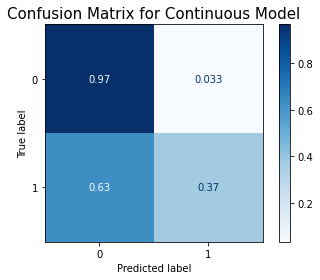

In [33]:
plot_confusion_matrix(cont_rf, X_test_sc, y_test, cmap='Blues', normalize='true')
plt.title('Confusion Matrix for Continuous Model', size = 15);

In [32]:
# Accuracy:  # What percentage of observation did I correctly predict?
print(f"The Accuracy score is: {round((TP + TN) / (TP + TN + FP + FN), 3) * 100}%")

# Misclassification: # What percentage of observation did I incorrectly predict?
print(f"The Missclassification rate is: {round((FP + FN) / (TP + TN + FP + FN), 4) * 100}%")

# Sensitivity:  # Among Positives, how many did I get correctly? Same as recall
print(f"The Sensitivity is: {round(TP / (TP + FN), 3) * 100}%")

# Specificity:  # Among Negatives, how many did I get correctly?
print(f"The Specificity is: {round(TN / (TN + FP), 3) * 100}%")

# Precision: # Among Positives, how many did I Predict correct
print(f"The Precision is {round(TP / (TP + FP), 4) * 100}%")

The Accuracy score is: 83.39999999999999%
The Missclassification rate is: 16.55%
The Sensitivity is: 37.0%
The Specificity is: 96.7%
The Precision is 75.89%
